## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from IPython.display import Image
import imageio
import os
import time
import pickle

tpu = True


In [ ]:
# Pour executer le code sur tpu :
# 1) Mettre tpu = True
# 2) Changer le type d'éxecution à TPU dans l'onglet execution
# 3) Lancer cette cellule avec la deuxieme ligne non commentée puis redemarrer l'environnement et commenter la ligne
if tpu:
    assert os.environ['COLAB_TPU_ADDR']
    # !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
    import torch_xla
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
else:
    dev ='cpu'


## Network Definition

### Layers

In [ ]:
def build_generator(n_img,n_noise):
    # Encoder network
    generator = nn.Sequential(
        
        nn.Linear(n_noise, 256*7*7), 
        nn.Unflatten(1,(256,7,7)),
        
        nn.ConvTranspose2d(256, 128, 3,stride=2,padding=1,output_padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(128, 64, 3,stride=1,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(64,1, 3,stride=2,padding=1,output_padding=1),
        nn.Tanh(),
    )
    return generator

In [ ]:
def build_discriminator(n_img,loss):
    # Encoder network
    discriminator = nn.Sequential(
        
        nn.Conv2d(1, 64, 3,stride=2,padding=1),
        nn.LeakyReLU(0.2),
        
        nn.Conv2d(64,128, 3,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Flatten(),
        nn.Linear(128*7*7,1))
    
    return discriminator

### Module Class


In [ ]:
class GAN(nn.Module):
    def __init__(self,flags):
        super().__init__()
        self.G = build_generator(flags['n_img'],flags['n_noise'])
        self.D = build_discriminator(flags['n_img'],flags['loss'])
        self.dev = flags['device']

    def generate(self, noise):
        return self.G(noise)#.view(-1, 1, 28, 28)
    def discriminate(self,image):
        x = image
        return self.D(x).view(-1,1)


    def compute_gp(self, images, fakes):
        batch_size = images.size(0)
        eps = torch.rand(batch_size, 1, 1, 1).to(self.dev)
        eps = eps.expand_as(images)
        interpolation = eps * images + (1 - eps) * fakes
        interp_logits = self.discriminate(interpolation)
        grad_outputs = torch.ones_like(interp_logits)

        gradients = torch.autograd.grad(
            outputs=interp_logits,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
        )[0]

        gradients = gradients.view(batch_size, -1)
        grad_norm = gradients.norm(2, 1)
        return torch.mean((grad_norm - 1) ** 2)

### Data Loader

In [ ]:
def import_data(batch_size):
# Transforms to apply to the images
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),])
# Import the train dataset
  path = r'.\Dataset'
  trainset = torchvision.datasets.MNIST(root=path, train=True, download=True, transform=transform)
  if small_set==True:
    trainset, val_set = torch.utils.data.random_split(trainset, [2048, len(trainset)-2048])

  if tpu == True:
    train_sampler = torch.utils.data.distributed.DistributedSampler(trainset,
                                                                      num_replicas = xm.xrt_world_size(),
                                                                      rank         = xm.get_ordinal(),
                                                                      shuffle      = True)
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'],sampler=train_sampler,num_workers=0,pin_memory=True)
  else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=flags['batch_size'])

  return(trainloader)

### Some utility Functions

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
      
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def imshow(img,ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if ax==None:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()
    else:
      ax.imshow(np.transpose(npimg, (1, 2, 0)))
    
# save the generated images as GIF file
def save_gif(img_list):
    to_pil_image = transforms.ToPILImage()

    imgs = [np.array(to_pil_image(vutils.make_grid(img, padding=2))) for img in img_list]
    imageio.mimsave('./generator_images.gif', imgs)

def test_loader(trainloader):
# get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
# show images
    images.shape
    imshow(torchvision.utils.make_grid(images[:64]))
    plt.show()

In [ ]:
class MyHingeLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, output, target,dev):
        return (torch.mean(torch.maximum(1 - torch.mul(output, target),torch.zeros(output.shape[0],1).to(dev)),0))

class MyLinearLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, output, target):
        return torch.mean(torch.mul(target,output),0)     


## Running Functions

### Initialisation

In [ ]:
def create_network(flags,dev):
  trainloader = import_data(flags['batch_size'])
  fixed_noise = torch.randn(64, flags['n_noise']).to(dev) #Fixed noise for evaluation of the samples

  my_gan = GAN(flags)
  my_gan = xmp.MpModelWrapper(my_gan).to(dev)
  
  my_gan.G.apply(weights_init)
  my_gan.D.apply(weights_init)

  if flags['loss'] == 'wass':
    criterion1 = MyLinearLoss()
    criterion2 = MyLinearLoss()
  
  if flags['optim'] == 'rmsprop':
    optimizerG = optim.RMSprop(my_gan.G.parameters(),lr=flags['lr'])
    optimizerD = optim.RMSprop(my_gan.D.parameters(),lr=flags['lr'])
  else:
    optimizerG = optim.Adam(my_gan.G.parameters(),lr=flags['lr'], betas=(0.5, 0.999))
    optimizerD = optim.Adam(my_gan.D.parameters(),lr=flags['lr'], betas=(0.5, 0.999))
  
  my_gan.D.train()
  my_gan.G.train()

  return(my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise)



### Training Loop

In [ ]:
def train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev):
  
  img_list,G_losses,D_losses,accuracies1,accuracies2 = [],[],[],[],[]
  
  for epoch in range(flags['num_epochs']): 
        time_start = time.time()      
        D_loss,G_loss = 0.,0. #Variables for storing the losses

        # Select the DataLoader
        if tpu:
            para_loader = pl.ParallelLoader(trainloader, [dev])
            loader = para_loader.per_device_loader(dev)
        else:
            loader = trainloader

        iters_g ,iters_d =0 , 0 
        for i, data in enumerate(loader):        
            current_bsize = data[0].shape[0]  

            #### TRAINING THE DISCRIMINATOR #####
            optimizerD.zero_grad()
            label_real = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
            label_fake = (flags['label_fake'] + torch.zeros(current_bsize,1)).to(dev) 
            #REAL DATA
            output_real = my_gan.discriminate(data[0])
            #TFAKE DATA
            noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
            fakes = my_gan.generate(noise)
            output_fake = my_gan.discriminate(fakes)
            
            #COMPUTE LOSS
            errD_real = criterion1(output_real, label_real)
            errD_fake = criterion1(output_fake, label_fake)  


            loss_im = (errD_real + errD_fake)
            loss_grad = my_gan.compute_gp(data[0],fakes)
            loss = loss_im + flags['grad_penalty'] * loss_grad


            loss.backward()
          
            if tpu:
                xm.optimizer_step(optimizerD)
            else:
                optimizerD.step()
            
            if flags['clipping'] == True:
                for p in my_gan.D.parameters():
                  p.data.clamp_(-0.01, 0.01)

            #Saving the loss
          
            D_loss+=loss.item()
            iters_d +=1
            #### TRAINING THE GENERATOR #####
            if (i+1)%flags['epochs_discr'] == 0:
              optimizerG.zero_grad()
              label = (flags['label_real'] + torch.zeros(current_bsize,1)).to(dev)
              noise = torch.randn(current_bsize, flags['n_noise']).to(dev)
              fakes = my_gan.generate(noise)
              output = my_gan.discriminate(fakes)
              errG = criterion2(output, label)
              errG.backward()
              if tpu:
                xm.optimizer_step(optimizerG)
              else:
                optimizerG.step()
              G_loss+=errG.item()
              iters_g += 1
        
        #On calcule la loss moyennée sur le batch
        G_loss,D_loss = G_loss/(iters_g),D_loss/(iters_d)
        G_losses.append(G_loss)
        D_losses.append(D_loss)

        time_end = time.time()
        time_spent = time_end-time_start          
        xm.master_print('[%d/%d] \tTime Spent: %.4f \tLoss_D: %.4f   \tLoss_G:  %.4f'
                      % (epoch, flags['num_epochs'], time_spent,
                        D_loss, G_loss))
            
        with torch.no_grad():
            fakes = my_gan.generate(fixed_noise)
            img_list.append(fakes.cpu())
            
            if xm.is_master_ordinal() and epoch%20 == 0: # On montre les images toutes les 20 epochs
              image = vutils.make_grid(fakes.cpu(), padding=2, normalize=False)
              plt.figure()
              plt.axis("off")
              plt.title("Epoch : " + str(i) +" Image Generation")
              imshow(image)
              plt.show()
        
        if xm.is_master_ordinal() and epoch%20 == 0  or epoch==flags['num_epochs']-1: # On sauve les données et le modèle toutes les 20 epoches
          open_file = open('Outputs_'+flags['Simu_name']+'.pkl', "wb")
          pickle.dump([D_losses,G_losses,img_list], open_file)
          open_file.close()
  return(D_losses,G_losses,accuracies1,accuracies2,img_list)

In [ ]:
def map_fn(index,flags): #Map function pour le calcul multi-coeurs
  dev = xm.xla_device()
  flags['device'] = dev
  torch.manual_seed(flags['seed'])
  my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise = create_network(flags,dev)
  D_losses,G_losses,img_list = train(flags,my_gan,criterion1,criterion2,optimizerG,optimizerD,trainloader,fixed_noise,dev)
  
  open_file = open('Outputs_'+flags['Simu_name']+'.pkl', "wb")
  pickle.dump([D_losses,G_losses,img_list], open_file)
  open_file.close()

  open_file = open('Outputs_'+flags['Simu_name']+'_MODEL.pkl', "wb")
  pickle.dump(my_gan.cpu(), open_file)
  open_file.close()


## Train the model

In [ ]:
test = False
if test:
  dev = 'cpu'
  my_gan = GAN(flags).to(dev)
  fixed_noise = torch.randn(3, flags['n_noise']).to(dev)
  fake = my_gan.generate(fixed_noise)
  output = my_gan.discriminate(fake).to(dev)
  print(output)
  print(my_gan._compute_gp( fake*2, fake))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\Dataset/MNIST/raw/train-images-idx3-ubyte.gz to .\Dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\Dataset/MNIST/raw/train-labels-idx1-ubyte.gz to .\Dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\Dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to .\Dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\Dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to .\Dataset/MNIST/raw

[0/200] 	Time Spent: 43.0719 	Loss_D: -10.4026   	Loss_G:  4.9893


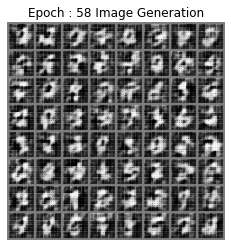

[1/200] 	Time Spent: 15.4175 	Loss_D: -12.9163   	Loss_G:  8.4278
[2/200] 	Time Spent: 16.2877 	Loss_D: -9.3572   	Loss_G:  9.7678
[3/200] 	Time Spent: 16.5161 	Loss_D: -7.1186   	Loss_G:  9.7421
[4/200] 	Time Spent: 16.1643 	Loss_D: -5.5271   	Loss_G:  9.0502
[5/200] 	Time Spent: 18.2518 	Loss_D: -4.2716   	Loss_G:  7.5969
[6/200] 	Time Spent: 16.2244 	Loss_D: -3.3404   	Loss_G:  5.7363
[7/200] 	Time Spent: 16.2267 	Loss_D: -2.9165   	Loss_G:  4.3854
[8/200] 	Time Spent: 16.2539 	Loss_D: -2.8368   	Loss_G:  2.5416
[9/200] 	Time Spent: 16.5169 	Loss_D: -2.2532   	Loss_G:  5.1713
[10/200] 	Time Spent: 16.5182 	Loss_D: -2.5166   	Loss_G:  4.5918
[11/200] 	Time Spent: 16.9912 	Loss_D: -2.6197   	Loss_G:  3.6552
[12/200] 	Time Spent: 16.3366 	Loss_D: -2.1168   	Loss_G:  5.0529
[13/200] 	Time Spent: 16.5805 	Loss_D: -2.4813   	Loss_G:  3.1962
[14/200] 	Time Spent: 16.2545 	Loss_D: -2.1907   	Loss_G:  3.3785
[15/200] 	Time Spent: 16.1677 	Loss_D: -2.1379   	Loss_G:  2.0746
[16/200] 	Time Spe

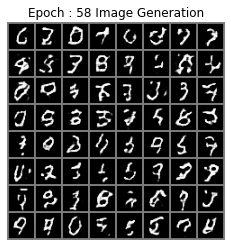

[21/200] 	Time Spent: 15.8235 	Loss_D: -1.9416   	Loss_G:  1.5043
[22/200] 	Time Spent: 16.0598 	Loss_D: -1.8002   	Loss_G:  1.9261
[23/200] 	Time Spent: 16.1736 	Loss_D: -1.6745   	Loss_G:  2.4803
[24/200] 	Time Spent: 16.3045 	Loss_D: -1.8062   	Loss_G:  1.3162
[25/200] 	Time Spent: 15.9805 	Loss_D: -1.7688   	Loss_G:  2.2384
[26/200] 	Time Spent: 16.2268 	Loss_D: -1.7104   	Loss_G:  2.3689
[27/200] 	Time Spent: 15.6171 	Loss_D: -1.1624   	Loss_G:  1.8724
[28/200] 	Time Spent: 15.9882 	Loss_D: -0.7277   	Loss_G:  1.9320
[29/200] 	Time Spent: 16.4555 	Loss_D: -1.3751   	Loss_G:  0.1331
[30/200] 	Time Spent: 15.9895 	Loss_D: -1.5374   	Loss_G:  -0.4873
[31/200] 	Time Spent: 16.5538 	Loss_D: -1.3973   	Loss_G:  0.1100
[32/200] 	Time Spent: 16.3394 	Loss_D: -1.4533   	Loss_G:  -0.4360
[33/200] 	Time Spent: 15.9482 	Loss_D: -1.4525   	Loss_G:  0.0077
[34/200] 	Time Spent: 16.2596 	Loss_D: -1.4647   	Loss_G:  0.3521
[35/200] 	Time Spent: 15.9139 	Loss_D: -1.4954   	Loss_G:  0.1138
[36/200]

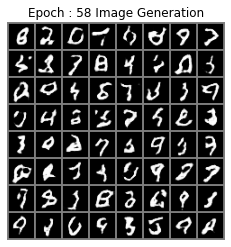

[41/200] 	Time Spent: 16.1731 	Loss_D: -1.3720   	Loss_G:  2.0264
[42/200] 	Time Spent: 17.0439 	Loss_D: -1.4181   	Loss_G:  1.6052
[43/200] 	Time Spent: 16.8430 	Loss_D: -1.3809   	Loss_G:  1.9682
[44/200] 	Time Spent: 16.9064 	Loss_D: -1.4250   	Loss_G:  2.0545
[45/200] 	Time Spent: 16.5403 	Loss_D: -1.1022   	Loss_G:  3.1215
[46/200] 	Time Spent: 16.0690 	Loss_D: -1.4453   	Loss_G:  2.6484
[47/200] 	Time Spent: 16.3631 	Loss_D: -1.4131   	Loss_G:  2.5013
[48/200] 	Time Spent: 16.3652 	Loss_D: -1.4545   	Loss_G:  2.1353
[49/200] 	Time Spent: 16.4953 	Loss_D: -1.4675   	Loss_G:  1.9989
[50/200] 	Time Spent: 16.9572 	Loss_D: -1.3617   	Loss_G:  2.4695
[51/200] 	Time Spent: 17.2191 	Loss_D: -1.4277   	Loss_G:  1.9491
[52/200] 	Time Spent: 17.6868 	Loss_D: -1.3650   	Loss_G:  2.4847
[53/200] 	Time Spent: 17.3986 	Loss_D: -1.5102   	Loss_G:  1.1112
[54/200] 	Time Spent: 17.7800 	Loss_D: -1.3601   	Loss_G:  1.9032
[55/200] 	Time Spent: 17.7289 	Loss_D: -1.6104   	Loss_G:  0.5955
[56/200] 	

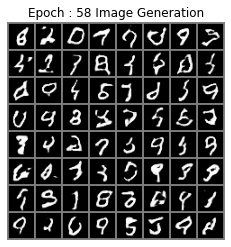

[61/200] 	Time Spent: 16.4130 	Loss_D: -1.4669   	Loss_G:  1.8138
[62/200] 	Time Spent: 17.2575 	Loss_D: -1.4438   	Loss_G:  2.1088
[63/200] 	Time Spent: 16.9584 	Loss_D: -1.4911   	Loss_G:  2.3375
[64/200] 	Time Spent: 17.3670 	Loss_D: -1.4815   	Loss_G:  1.5864
[65/200] 	Time Spent: 17.4050 	Loss_D: -1.5253   	Loss_G:  2.2849
[66/200] 	Time Spent: 17.5524 	Loss_D: -1.5828   	Loss_G:  2.1113
[67/200] 	Time Spent: 17.6092 	Loss_D: -1.4930   	Loss_G:  1.8196
[68/200] 	Time Spent: 17.5733 	Loss_D: -1.5247   	Loss_G:  2.5240
[69/200] 	Time Spent: 17.1514 	Loss_D: -1.5766   	Loss_G:  2.4218
[70/200] 	Time Spent: 16.6030 	Loss_D: -1.6115   	Loss_G:  2.5573
[71/200] 	Time Spent: 16.6788 	Loss_D: -1.3947   	Loss_G:  2.8154
[72/200] 	Time Spent: 16.5723 	Loss_D: -1.2786   	Loss_G:  4.2432
[73/200] 	Time Spent: 16.4285 	Loss_D: -1.4931   	Loss_G:  2.6701
[74/200] 	Time Spent: 16.5913 	Loss_D: -1.5615   	Loss_G:  2.4128
[75/200] 	Time Spent: 16.4447 	Loss_D: -1.5203   	Loss_G:  2.3898
[76/200] 	

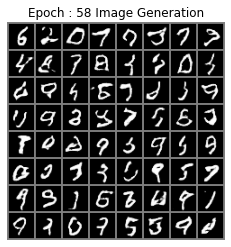

[81/200] 	Time Spent: 16.3440 	Loss_D: -1.4900   	Loss_G:  3.4315
[82/200] 	Time Spent: 17.6400 	Loss_D: -1.6239   	Loss_G:  3.1166
[83/200] 	Time Spent: 17.3786 	Loss_D: -1.5741   	Loss_G:  3.3935
[84/200] 	Time Spent: 17.1512 	Loss_D: -1.5714   	Loss_G:  3.3859
[85/200] 	Time Spent: 17.2898 	Loss_D: -1.5033   	Loss_G:  4.0586
[86/200] 	Time Spent: 16.9901 	Loss_D: -1.4992   	Loss_G:  3.4479
[87/200] 	Time Spent: 16.2476 	Loss_D: -0.8840   	Loss_G:  3.8992
[88/200] 	Time Spent: 16.7885 	Loss_D: -1.4703   	Loss_G:  3.1919
[89/200] 	Time Spent: 16.4618 	Loss_D: -1.6536   	Loss_G:  3.5659
[90/200] 	Time Spent: 16.6454 	Loss_D: -1.6114   	Loss_G:  4.4820
[91/200] 	Time Spent: 16.4975 	Loss_D: -1.7364   	Loss_G:  3.4264
[92/200] 	Time Spent: 16.8337 	Loss_D: -1.6527   	Loss_G:  3.3297
[93/200] 	Time Spent: 17.2819 	Loss_D: -1.6895   	Loss_G:  3.1026
[94/200] 	Time Spent: 17.5285 	Loss_D: -1.7211   	Loss_G:  1.9178
[95/200] 	Time Spent: 17.5622 	Loss_D: -1.6493   	Loss_G:  2.4587
[96/200] 	

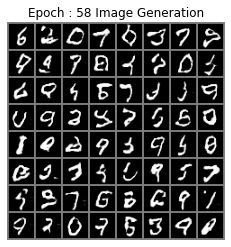

[101/200] 	Time Spent: 14.6285 	Loss_D: -0.3057   	Loss_G:  1.9575
[102/200] 	Time Spent: 16.6304 	Loss_D: -0.3361   	Loss_G:  3.3165
[103/200] 	Time Spent: 16.9476 	Loss_D: -0.3834   	Loss_G:  3.6112
[104/200] 	Time Spent: 16.9450 	Loss_D: -0.3742   	Loss_G:  3.4581
[105/200] 	Time Spent: 17.2458 	Loss_D: -0.4209   	Loss_G:  3.6717
[106/200] 	Time Spent: 17.1556 	Loss_D: -0.4484   	Loss_G:  3.8107
[107/200] 	Time Spent: 17.3980 	Loss_D: -0.4619   	Loss_G:  4.1020
[108/200] 	Time Spent: 17.5035 	Loss_D: -0.4517   	Loss_G:  4.1451
[109/200] 	Time Spent: 17.0012 	Loss_D: -0.4779   	Loss_G:  4.2810
[110/200] 	Time Spent: 16.8741 	Loss_D: -0.4975   	Loss_G:  4.2759
[111/200] 	Time Spent: 16.7764 	Loss_D: -0.4765   	Loss_G:  4.0394
[112/200] 	Time Spent: 16.6422 	Loss_D: -0.4478   	Loss_G:  3.9120
[113/200] 	Time Spent: 16.4917 	Loss_D: -0.4551   	Loss_G:  3.8540
[114/200] 	Time Spent: 16.2090 	Loss_D: -0.4663   	Loss_G:  3.5084
[115/200] 	Time Spent: 16.1629 	Loss_D: -0.4908   	Loss_G:  3.

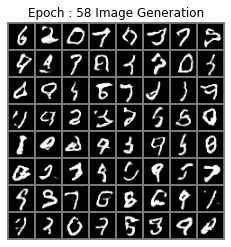

[121/200] 	Time Spent: 15.2337 	Loss_D: -0.7562   	Loss_G:  1.7210
[122/200] 	Time Spent: 16.4006 	Loss_D: -0.7351   	Loss_G:  2.1197
[123/200] 	Time Spent: 16.6301 	Loss_D: -0.7501   	Loss_G:  2.7071
[124/200] 	Time Spent: 16.3515 	Loss_D: -0.7518   	Loss_G:  3.6734
[125/200] 	Time Spent: 16.7114 	Loss_D: -0.8801   	Loss_G:  3.2196
[126/200] 	Time Spent: 16.6697 	Loss_D: -0.9094   	Loss_G:  3.3213
[127/200] 	Time Spent: 16.4358 	Loss_D: -0.5244   	Loss_G:  5.2791
[128/200] 	Time Spent: 16.3502 	Loss_D: -0.5348   	Loss_G:  6.8799
[129/200] 	Time Spent: 16.6525 	Loss_D: -0.7260   	Loss_G:  5.4939
[130/200] 	Time Spent: 16.8264 	Loss_D: -0.9731   	Loss_G:  5.4187
[131/200] 	Time Spent: 17.0556 	Loss_D: -1.0919   	Loss_G:  5.0079
[132/200] 	Time Spent: 17.4058 	Loss_D: -1.2805   	Loss_G:  4.6106
[133/200] 	Time Spent: 17.1486 	Loss_D: -1.1978   	Loss_G:  5.1320
[134/200] 	Time Spent: 16.8044 	Loss_D: -1.2209   	Loss_G:  4.8910
[135/200] 	Time Spent: 17.0961 	Loss_D: -1.3895   	Loss_G:  4.

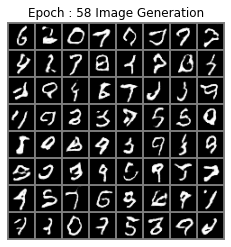

[141/200] 	Time Spent: 15.9047 	Loss_D: -1.6176   	Loss_G:  2.7902
[142/200] 	Time Spent: 17.0190 	Loss_D: -1.5565   	Loss_G:  2.7214
[143/200] 	Time Spent: 16.8053 	Loss_D: -1.4595   	Loss_G:  3.1444
[144/200] 	Time Spent: 17.0392 	Loss_D: -1.6269   	Loss_G:  2.3261
[145/200] 	Time Spent: 16.8470 	Loss_D: -1.4004   	Loss_G:  2.4278
[146/200] 	Time Spent: 16.8669 	Loss_D: -1.6343   	Loss_G:  2.1568
[147/200] 	Time Spent: 17.1146 	Loss_D: -1.5100   	Loss_G:  2.3762
[148/200] 	Time Spent: 16.9236 	Loss_D: -1.7123   	Loss_G:  1.4084
[149/200] 	Time Spent: 17.0505 	Loss_D: -1.4749   	Loss_G:  1.4869
[150/200] 	Time Spent: 17.0823 	Loss_D: -1.7110   	Loss_G:  1.8687
[151/200] 	Time Spent: 16.9595 	Loss_D: -1.6119   	Loss_G:  3.1300
[152/200] 	Time Spent: 17.0299 	Loss_D: -1.5011   	Loss_G:  2.1485
[153/200] 	Time Spent: 17.1041 	Loss_D: -1.4946   	Loss_G:  1.5459
[154/200] 	Time Spent: 17.5244 	Loss_D: -1.6456   	Loss_G:  1.2199
[155/200] 	Time Spent: 17.1817 	Loss_D: -1.6066   	Loss_G:  1.

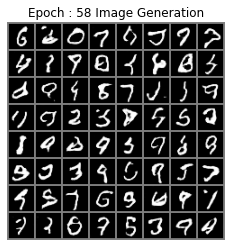

[161/200] 	Time Spent: 15.9946 	Loss_D: -1.7323   	Loss_G:  1.8125
[162/200] 	Time Spent: 16.9443 	Loss_D: -1.7454   	Loss_G:  1.2042
[163/200] 	Time Spent: 17.1120 	Loss_D: -1.7477   	Loss_G:  2.1062
[164/200] 	Time Spent: 17.1707 	Loss_D: -1.6926   	Loss_G:  2.3233
[165/200] 	Time Spent: 16.7547 	Loss_D: -1.7747   	Loss_G:  1.8998
[166/200] 	Time Spent: 16.7546 	Loss_D: -1.0117   	Loss_G:  2.5500
[167/200] 	Time Spent: 16.9581 	Loss_D: -1.5520   	Loss_G:  1.1454
[168/200] 	Time Spent: 16.8129 	Loss_D: -1.7529   	Loss_G:  1.1489
[169/200] 	Time Spent: 16.7507 	Loss_D: -1.9353   	Loss_G:  1.7221
[170/200] 	Time Spent: 16.7801 	Loss_D: -1.5698   	Loss_G:  2.0556
[171/200] 	Time Spent: 16.8275 	Loss_D: -1.7828   	Loss_G:  1.4437
[172/200] 	Time Spent: 16.8296 	Loss_D: -1.9733   	Loss_G:  1.9307
[173/200] 	Time Spent: 16.9789 	Loss_D: -1.9036   	Loss_G:  1.9988
[174/200] 	Time Spent: 17.3527 	Loss_D: -1.6879   	Loss_G:  1.6925
[175/200] 	Time Spent: 17.2596 	Loss_D: -1.8259   	Loss_G:  1.

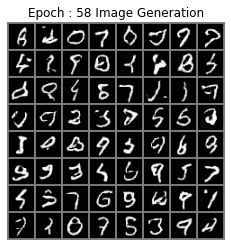

[181/200] 	Time Spent: 15.8885 	Loss_D: -1.0397   	Loss_G:  5.2985
[182/200] 	Time Spent: 17.2726 	Loss_D: -1.8246   	Loss_G:  1.0805
[183/200] 	Time Spent: 17.1168 	Loss_D: -1.6811   	Loss_G:  1.8178
[184/200] 	Time Spent: 17.1990 	Loss_D: -1.9234   	Loss_G:  1.9134
[185/200] 	Time Spent: 17.2296 	Loss_D: -1.9872   	Loss_G:  2.1166
[186/200] 	Time Spent: 17.1136 	Loss_D: -2.0392   	Loss_G:  1.7848
[187/200] 	Time Spent: 17.1931 	Loss_D: -1.9165   	Loss_G:  1.1016
[188/200] 	Time Spent: 16.9536 	Loss_D: -1.9564   	Loss_G:  0.5665
[189/200] 	Time Spent: 17.4254 	Loss_D: -1.7886   	Loss_G:  0.9126
[190/200] 	Time Spent: 17.4846 	Loss_D: -1.9399   	Loss_G:  0.4682
[191/200] 	Time Spent: 16.8321 	Loss_D: -0.8340   	Loss_G:  4.0069
[192/200] 	Time Spent: 16.9651 	Loss_D: -0.9856   	Loss_G:  6.2330
[193/200] 	Time Spent: 16.7408 	Loss_D: -1.6028   	Loss_G:  2.4749
[194/200] 	Time Spent: 16.8115 	Loss_D: -1.8581   	Loss_G:  1.4747
[195/200] 	Time Spent: 17.7947 	Loss_D: -1.9079   	Loss_G:  0.

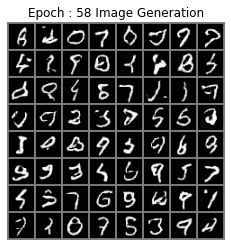

[181/200] 	Time Spent: 15.8885 	Loss_D: -1.0397   	Loss_G:  5.2985
[182/200] 	Time Spent: 17.2726 	Loss_D: -1.8246   	Loss_G:  1.0805
[183/200] 	Time Spent: 17.1168 	Loss_D: -1.6811   	Loss_G:  1.8178
[184/200] 	Time Spent: 17.1990 	Loss_D: -1.9234   	Loss_G:  1.9134
[185/200] 	Time Spent: 17.2296 	Loss_D: -1.9872   	Loss_G:  2.1166
[186/200] 	Time Spent: 17.1136 	Loss_D: -2.0392   	Loss_G:  1.7848
[187/200] 	Time Spent: 17.1931 	Loss_D: -1.9165   	Loss_G:  1.1016
[188/200] 	Time Spent: 16.9536 	Loss_D: -1.9564   	Loss_G:  0.5665
[190/200] 	Time Spent: 17.4846 	Loss_D: -1.9399   	Loss_G:  0.4682
[191/200] 	Time Spent: 16.8321 	Loss_D: -0.8340   	Loss_G:  4.0069
[192/200] 	Time Spent: 16.9651 	Loss_D: -0.9856   	Loss_G:  6.2330
[193/200] 	Time Spent: 16.7408 	Loss_D: -1.6028   	Loss_G:  2.4749
[194/200] 	Time Spent: 16.8115 	Loss_D: -1.8581   	Loss_G:  1.4747
[195/200] 	Time Spent: 17.7947 	Loss_D: -1.9079   	Loss_G:  0.3053
[196/200] 	Time Spent: 17.5771 	Loss_D: -2.0555   	Loss_G:  1.

In [ ]:
flags = {}
flags['clipping'] = False
flags['grad_penalty'] = 10
flags['Simu_name'] = 'Wass_grad_pen'
flags['loss'] = 'wass'
flags['label_real'] = 1
flags['label_fake'] = -1

flags['optim'] = 'adam'

flags['epochs_discr'] = 1
flags['n_img'] = 28
flags['n_noise'] = 100
flags['lr'] = 0.0002
flags['batch_size'] = 128
flags['num_epochs']= 200
flags['seed'] = 1234
small_set = False

xmp.spawn(map_fn, args=(flags,), nprocs=8, start_method='fork')

In [ ]:

from google.colab import files
files.download('./Outputs_Wass_clipping.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

In [ ]:
def plot_results(file,create_gif=False):
  open_file = open(file, "rb")
  [D_losses,G_losses,img_list] = pickle.load(open_file)
  open_file.close()

  # save_gif(img_list)
  f,ax = plt.subplots(1,1,figsize=(16,5))
  ax.plot(G_losses,label='Generator Loss')
  ax.plot(D_losses,label='Discriminator Loss')
  ax.legend()
  ax.set_xlabel('Epochs')

  plt.savefig('./loss.png')

  # Plot the fake images from the last epoch
  fakes = img_list[-1].cpu()
  images = vutils.make_grid(fakes, padding=2, normalize=False,nrow = 32)
  # Plot the fake images from the last epoch

  plt.figure(figsize=(16,4))
  plt.axis("off")
  plt.title("Last Epoch Image Generation")
  imshow(images)
  plt.show() 

def gif_trajectory(model_file):
    open_file = open(model_file, "rb")
    my_gan = pickle.load(open_file)
    open_file.close()
    noise =torch.randn(1, 100) 
    noise0 =torch.randn(1, 100) 
    img_list =[]
    noise_cur = noise
    for i in range(1000):
      if i%100==0:
        noise =torch.randn(1, 100) 
      noise_cur =  2*np.sin(2*np.pi/100*i)*noise + noise0
      fakes = my_gan.generate(noise_cur).detach()
      images = vutils.make_grid(fakes, padding=2, normalize=False,nrow=1)
      img_list.append(images)
      
    save_gif(img_list)


def plot_multiple_files(filenames):
  f,ax = plt.subplots(12,len(filenames),figsize=(28,45))

  for j,filename in enumerate(filenames):

    open_file = open(filename+'.pkl', "rb")
    [D_losses,G_losses,img_list] = pickle.load(open_file)
    open_file.close()

    ax[0,j].set_title(filename)
    ax[0,j].plot(G_losses,label='Generator Loss')
    ax[0,j].plot(D_losses,label='Discriminator Loss')
    ax[0,j].legend()
    ax[0,j].set_xlabel('Epochs')

    nb_image=len(img_list)-1
    for i in range(1,11+1):
      
      index = (i - 1)*nb_image//11
      fakes = img_list[index].cpu()
      images = vutils.make_grid(fakes, padding=2, normalize=False,nrow=16)
      ax[i,j].axis("off")
      ax[i,j].set_title('Epoch = '+str(index))
      imshow(images,ax=ax[i,j])
      Image(url='.\generator_images.gif',width = 800, height = 500)           

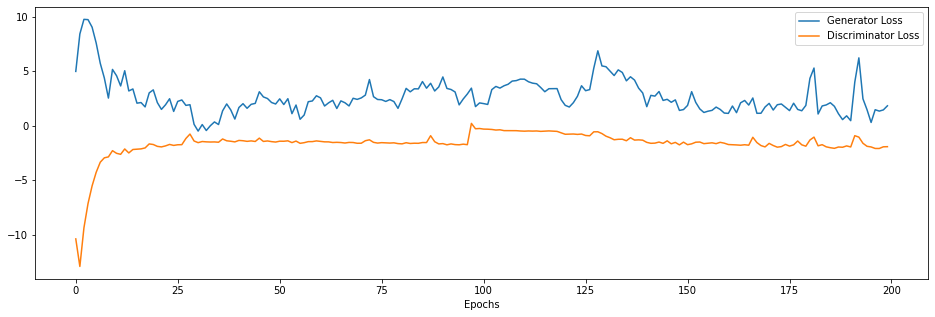

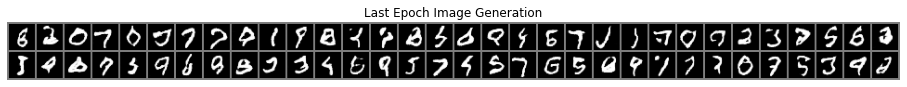

In [ ]:
plot_results('Outputs_Wass_grad_pen.pkl')

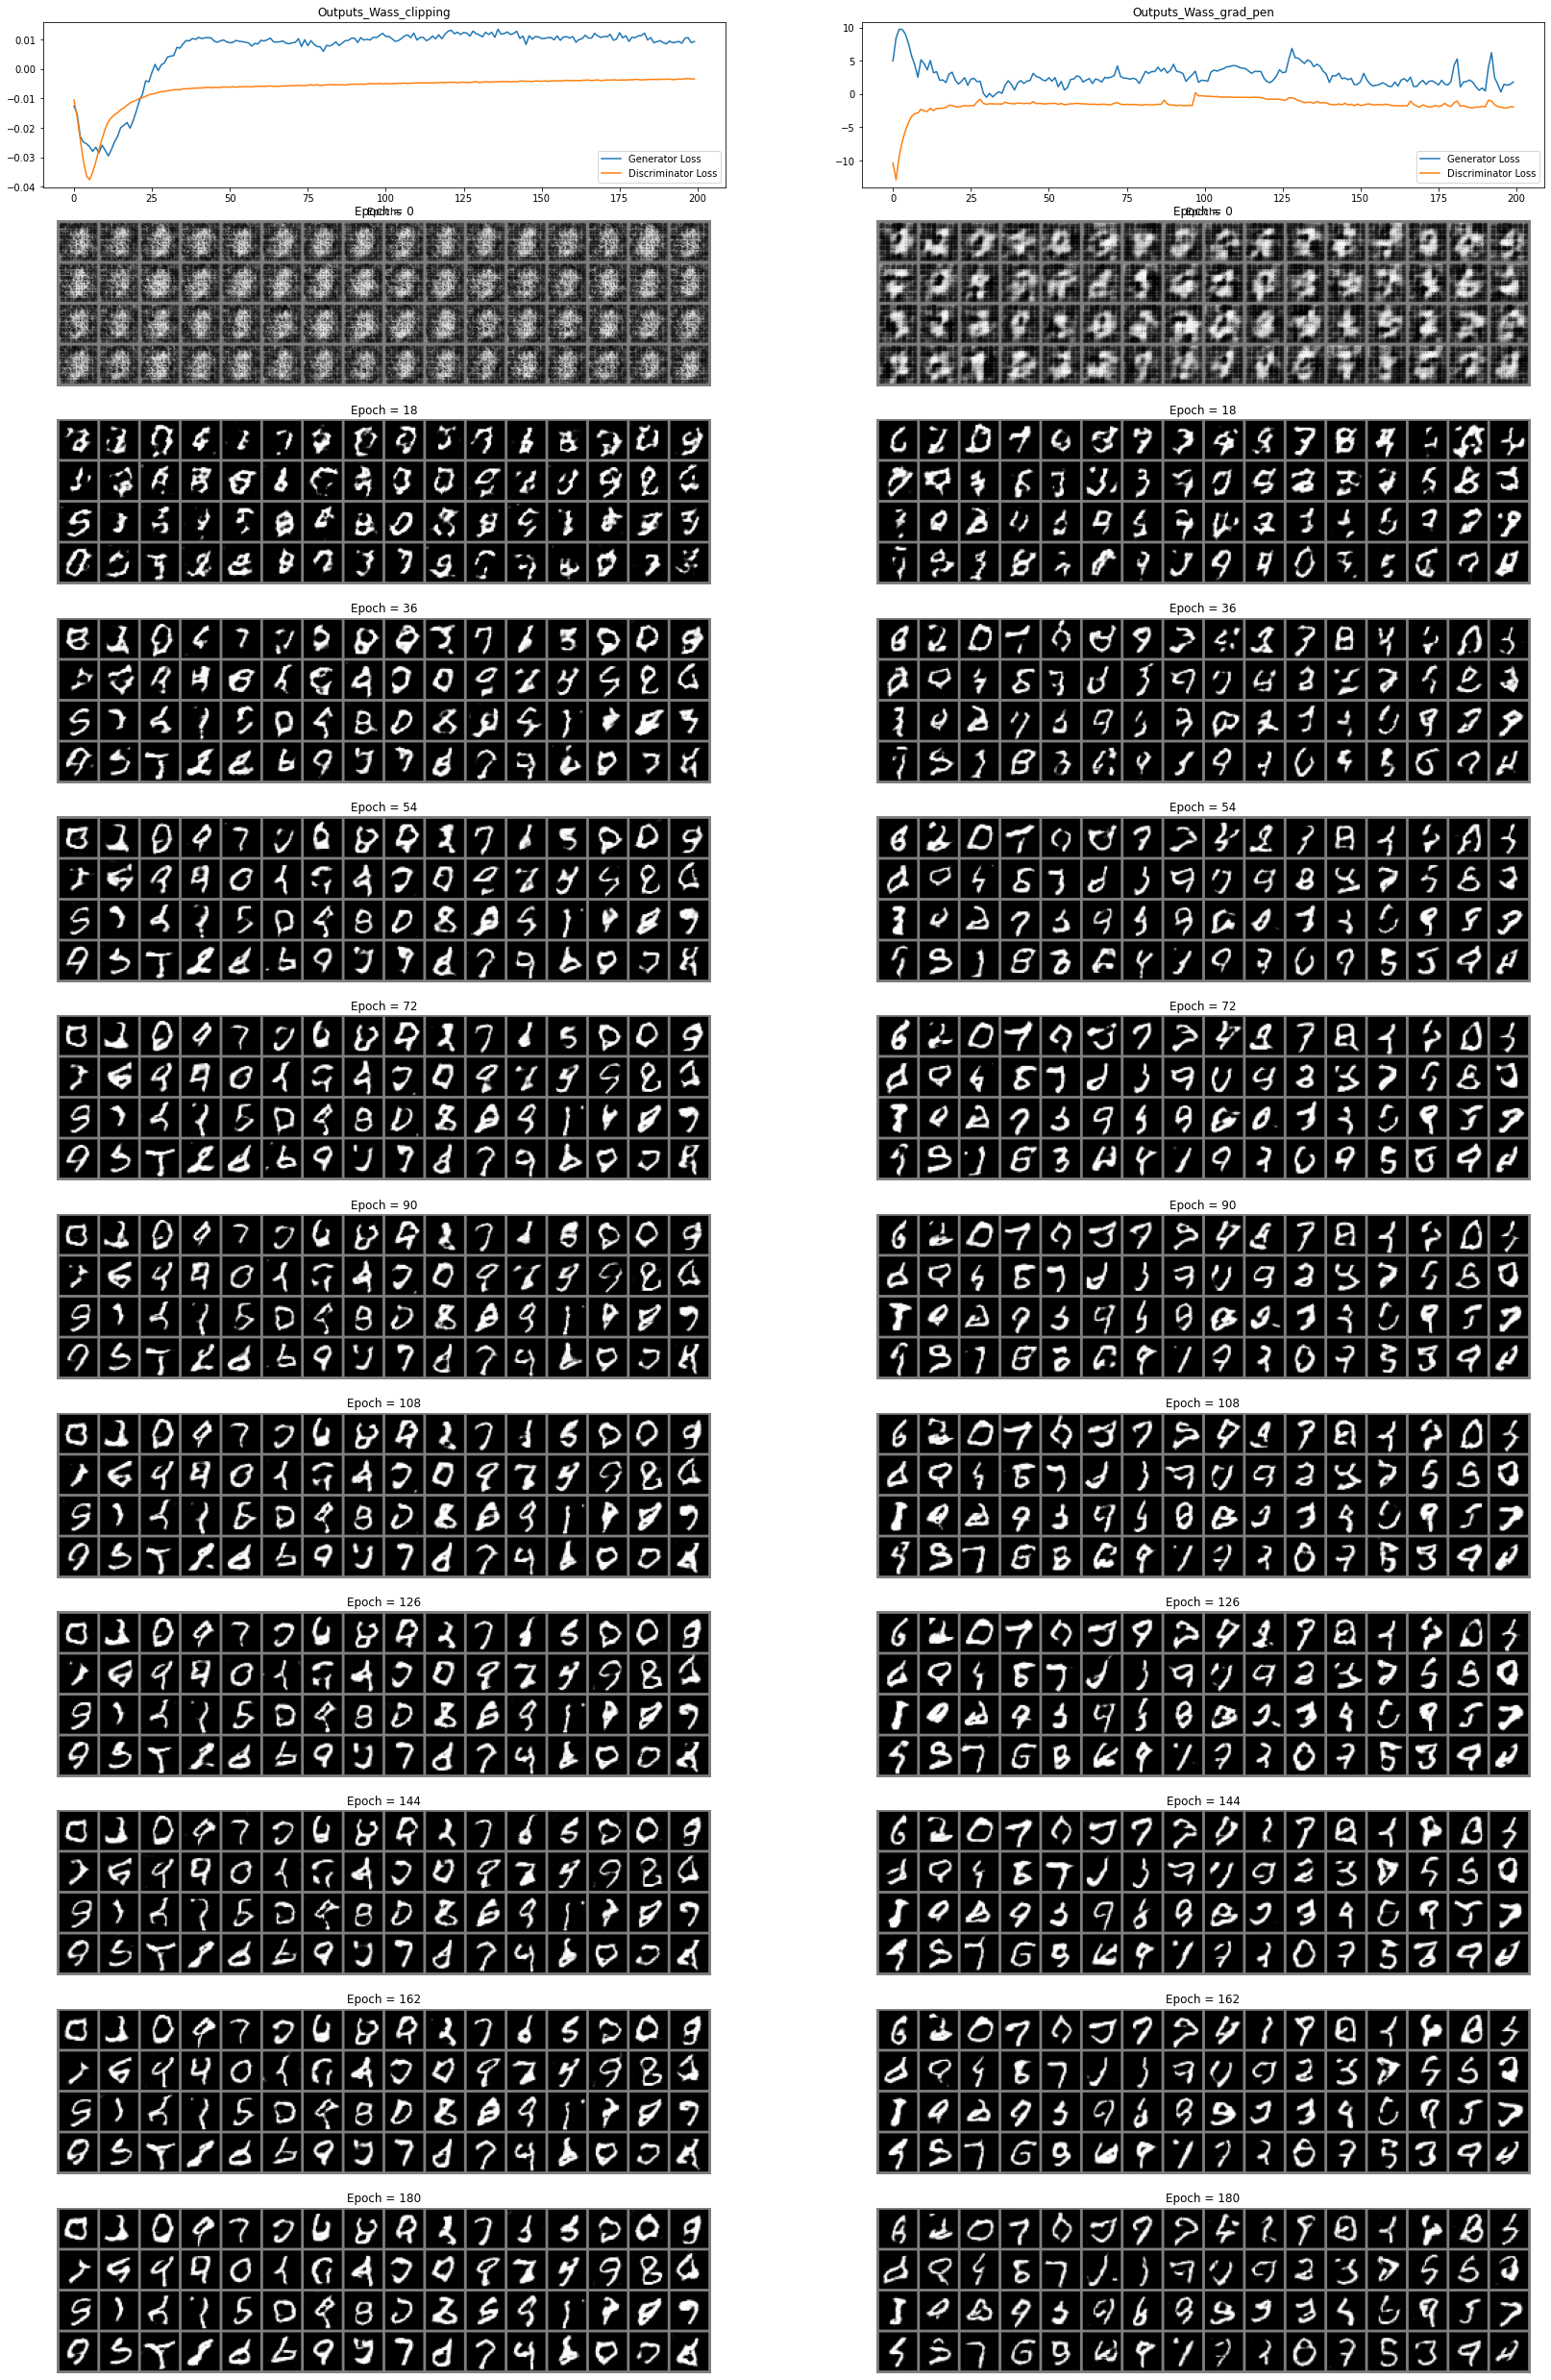

In [ ]:
filenames = ['Outputs_Wass_clipping','Outputs_Wass_grad_pen']
plot_multiple_files(filenames)


In [ ]:
file = 'Outputs_Wass_grad_pen_MODEL.pkl'
gif_trajectory(file)
files.download('./generator_images.gif')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>